## Project description

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Libraries importing

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## Data reading and preparation

### Reading

In [42]:
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong. Please, check file path.')

### Description

In [43]:
display(df.info())
display(df.describe())
print(f'NaN значения в dataframe:\n {df.isna().sum()}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


NaN значения в dataframe:
 num_orders    0
dtype: int64


### Resampling

In [44]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Посмотрю на распределение целевого признака.

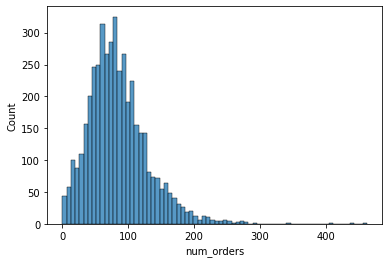

In [45]:
sns.histplot(data=df, x='num_orders')
plt.show()

Распределение близко к нормальному.

### Time series analysis

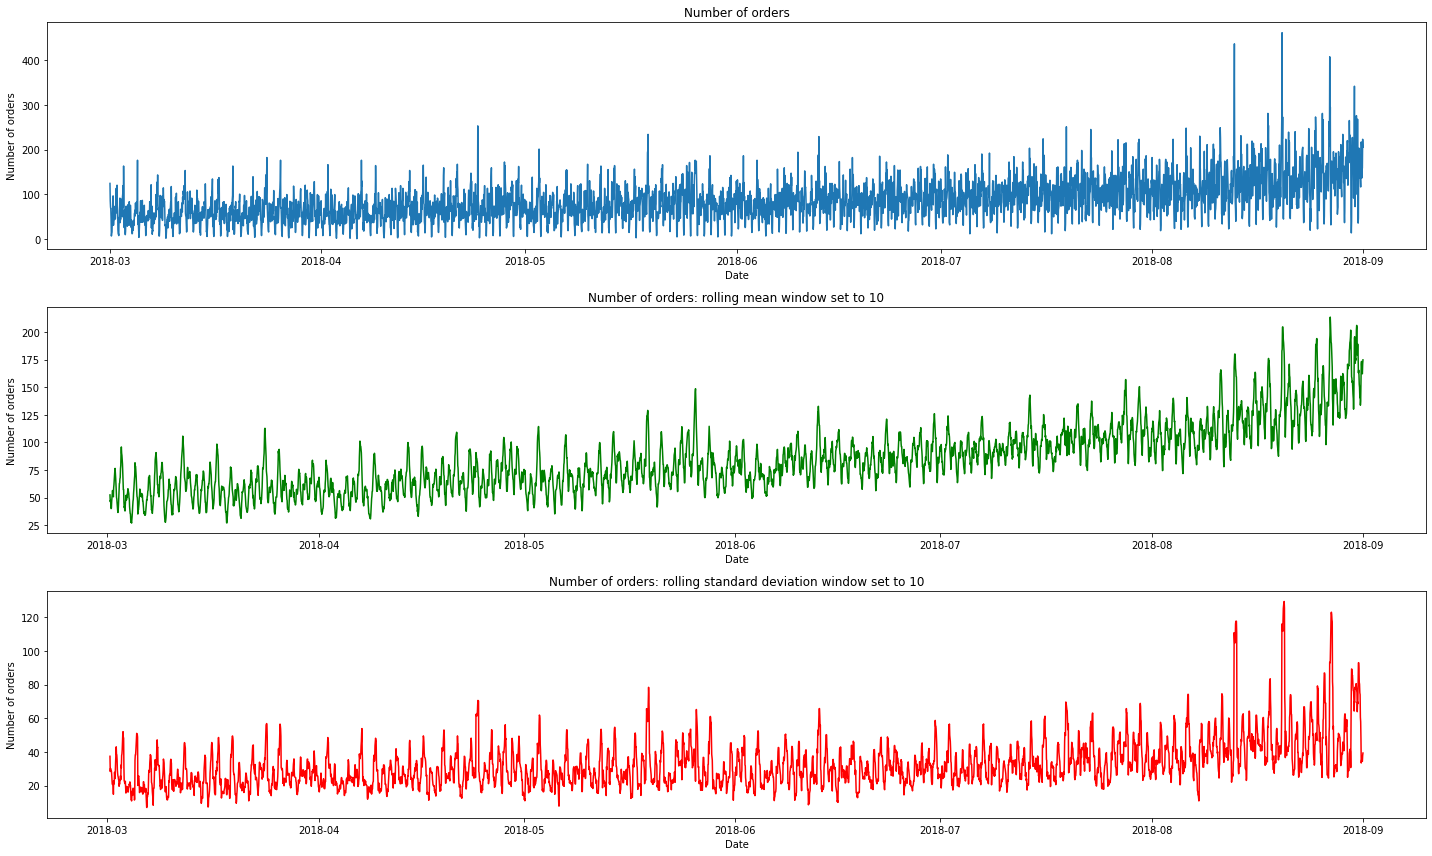

In [46]:
fig, ax = plt.subplots(3, 1, figsize=(20, 12), tight_layout=True)

ax[0].plot(df)
ax[0].set_title('Number of orders')
ax[0].set_ylabel('Number of orders')
ax[0].set_xlabel('Date')

ax[1].plot(df.rolling(10).mean(), color='green')
ax[1].set_title('Number of orders: rolling mean window set to 10')
ax[1].set_ylabel('Number of orders')
ax[1].set_xlabel('Date')

ax[2].plot(df.rolling(10).std(), color='red')
ax[2].set_title('Number of orders: rolling standard deviation window set to 10')
ax[2].set_ylabel('Number of orders')
ax[2].set_xlabel('Date')

plt.show()

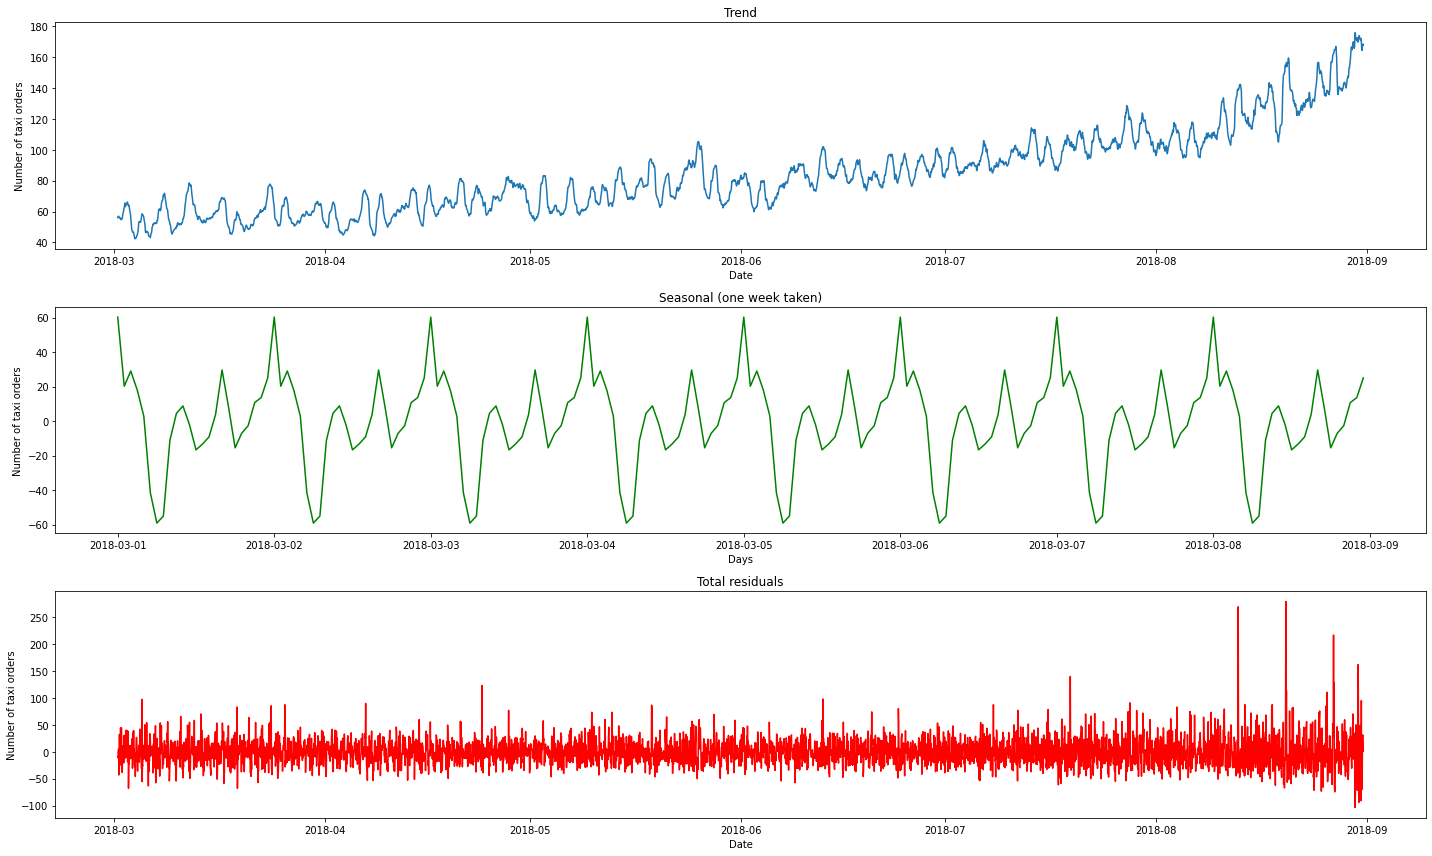

In [47]:
decomposed = seasonal_decompose(df)
fig, ax = plt.subplots(3, 1, figsize=(20, 12), tight_layout=True)

ax[0].plot(decomposed.trend)
ax[0].set_title('Trend')
ax[0].set_ylabel('Number of taxi orders')
ax[0].set_xlabel('Date')

ax[1].plot(decomposed.seasonal['2018-03-01':'2018-03-08'], color='green')
ax[1].set_title('Seasonal (one week taken)')
ax[1].set_ylabel('Number of taxi orders')
ax[1].set_xlabel('Days')

ax[2].plot(decomposed.resid, color='red')
ax[2].set_title('Total residuals')
ax[2].set_ylabel('Number of taxi orders')
ax[2].set_xlabel('Date')

plt.show()

Провожу тест Дики-Фуллера.

In [48]:
test = adfuller(df)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.0689242890279256
p-value:  0.02894005140261531
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


Вывод.  
Были проанализированы данные о заказах такси, а также выведен тренд по всему df и сезонность в течение недели. К концу дня количество заказов такси растет. К концу августа (началу учебного года), количество заказов тоже растет, что подтверждается трендом. Был проведен тест Дики-Фуллера, который подтвердил, что ряд стационарен.

## Building a prediction model

### Generation of features

Напишу функцию, которая создает features из даты, а также делает сдвиг с определенным шагом.

In [49]:
def make_features(data, max_lag, rolling_mean_size):
    # Создаю признаки из даты (индекса)
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Создаю признаки со сдвигом
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    for size in range(1, rolling_mean_size + 1):
        data['rolling_mean_{}'.format(size)] = data['num_orders'].shift(1).rolling(size).mean()    
    
    data = data.dropna()
    
    return data

### PACF

Построю график частной автокорреляционной функции, чтобы оценить количество лагов.

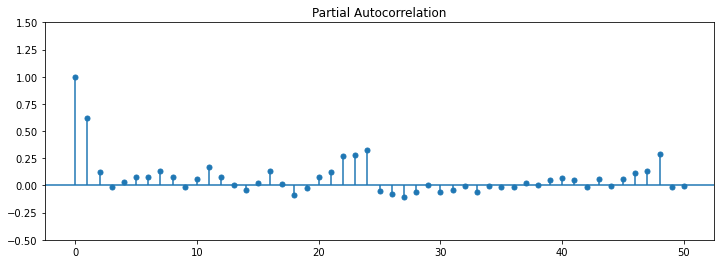

In [50]:
plot_pacf(df['num_orders'], lags=50, alpha=None, method='ywm').set_size_inches(12, 4)
plt.ylim([-0.5, 1.5])
plt.show()

### ACF

Построю график автокорреляционной функции, чтобы оценить количество порядок скользящего среднего.

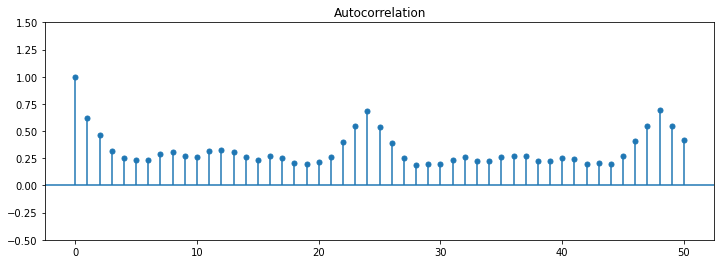

In [51]:
plot_acf(df['num_orders'], lags=50, alpha=None).set_size_inches(12, 4)
plt.ylim([-0.5, 1.5])
plt.show()

In [52]:
# Применяю функцию
df = make_features(df, max_lag=24, rolling_mean_size=25)
df

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,rolling_mean_16,rolling_mean_17,rolling_mean_18,rolling_mean_19,rolling_mean_20,rolling_mean_21,rolling_mean_22,rolling_mean_23,rolling_mean_24,rolling_mean_25
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,1,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,62.3750,60.705882,58.166667,55.736842,53.25,52.761905,53.363636,54.130435,55.416667,58.16
2018-03-02 02:00:00,75,2,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,65.5625,65.764706,64.000000,61.421053,58.95,56.428571,55.818182,56.260870,56.875000,58.00
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,66.2500,66.117647,66.277778,64.578947,62.10,59.714286,57.272727,56.652174,57.041667,57.60
2018-03-02 04:00:00,20,4,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,64.2500,66.117647,66.000000,66.157895,64.55,62.190476,59.909091,57.565217,56.958333,57.32
2018-03-02 05:00:00,11,5,2,4,20.0,64.0,75.0,120.0,90.0,58.0,...,63.6250,61.647059,63.555556,63.578947,63.85,62.428571,60.272727,58.173913,56.000000,55.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,152.5625,157.117647,159.166667,165.315789,169.35,168.809524,170.136364,168.913043,164.875000,165.36
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,154.8750,151.588235,155.944444,157.947368,163.85,167.761905,167.318182,168.652174,167.541667,163.72
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,147.7500,154.823529,151.722222,155.842105,157.75,163.380952,167.136364,166.739130,168.041667,167.00


### Data splitting

In [53]:
train, test = train_test_split(df, test_size=0.1, shuffle=False, random_state=0)

print(train.shape)
print(test.shape)
print('Last index (train):', train.index[-1])
print('First index (test):', test.index[0])

(3951, 53)
(440, 53)
Last index (train): 2018-08-13 15:00:00
First index (test): 2018-08-13 16:00:00


### Features extraction

In [54]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3951, 52)
(3951,)
(440, 52)
(440,)


### LinearRegression

In [55]:
model = LinearRegression()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred_test)**0.5)

RMSE обучающей выборки: 25.845398352338055
RMSE тестовой выборки:  45.23378857156539


### LightGBM

In [56]:
model = LGBMRegressor()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred_test)**0.5)

RMSE обучающей выборки: 12.166575907019942
RMSE тестовой выборки:  41.206450659098174


Проверю как влияли features во время обучения модели.

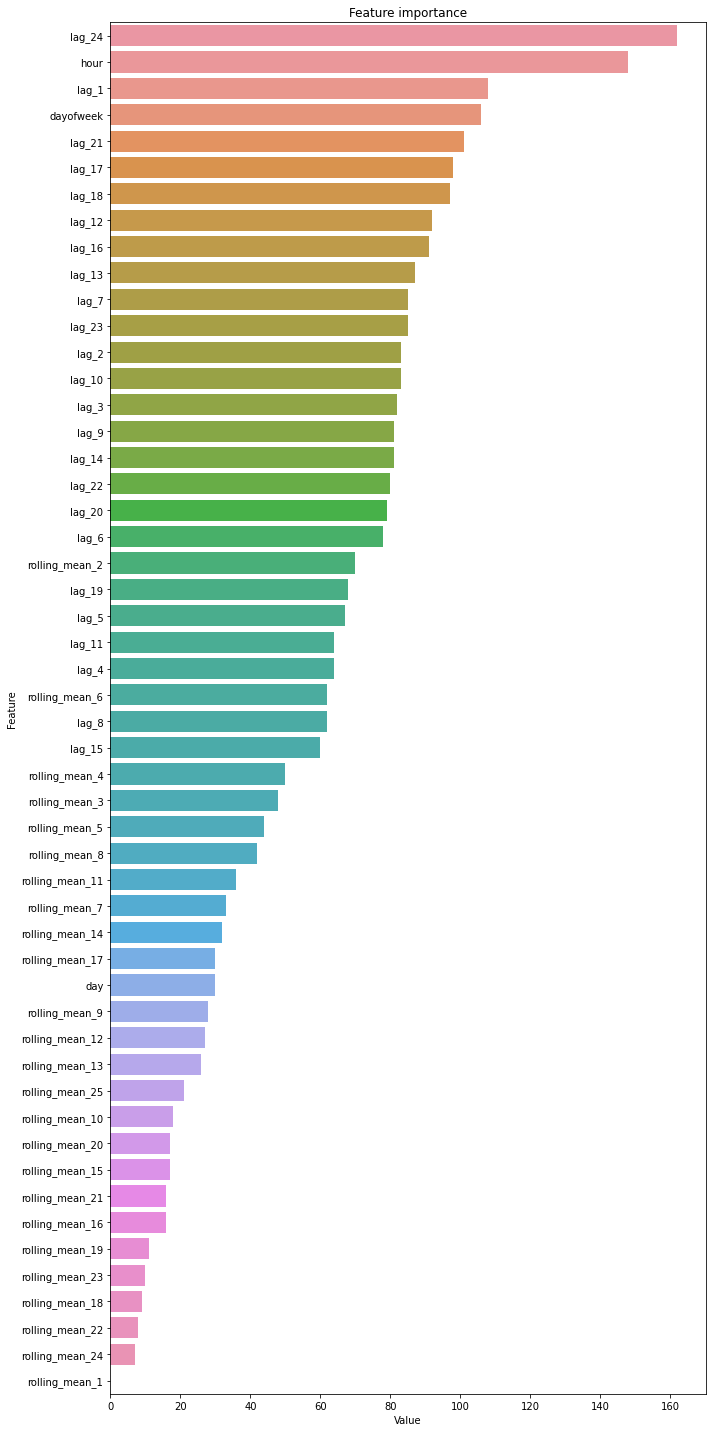

In [57]:
df_importances = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 20))
sns.barplot(x='Value', y='Feature', data=df_importances.sort_values(by='Value', ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show()

### RandomForestRegressor

#### GridSearchCV

In [58]:
tscv = TimeSeriesSplit(n_splits=5)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (10, 31, 10),
              'min_samples_leaf': range (1, 5),
              'min_samples_split': range (2, 10, 2) }
model = RandomForestRegressor()
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parametrs, n_jobs=-1)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(10, 31, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [59]:
gsearch.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 30}

In [60]:
pred_train = gsearch.predict(X_train)
pred_test = gsearch.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred_test)**0.5)

RMSE обучающей выборки: 10.032628676677318
RMSE тестовой выборки:  41.719082032396


#### Best parameters

In [61]:
model = RandomForestRegressor(max_depth=30, min_samples_leaf=4, 
                              min_samples_split=4, n_estimators=30, 
                              n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred_test)**0.5)

RMSE обучающей выборки: 12.350600791339925
RMSE тестовой выборки:  41.176141996973044


#### Predictions and true values

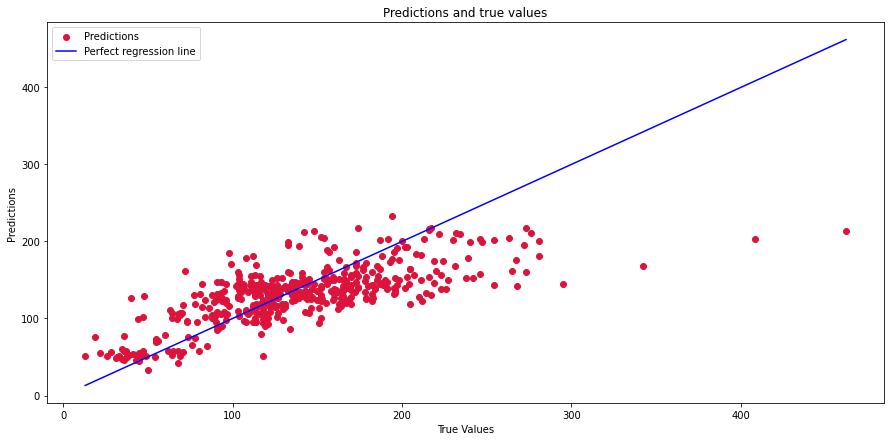

In [62]:
plt.figure(figsize=(15, 7))
plt.scatter(y_test, pred_test, c='crimson', label='Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions and true values')

p1 = max(max(pred_test), max(y_test))
p2 = min(min(pred_test), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label='Perfect regression line')
plt.legend()

plt.show()

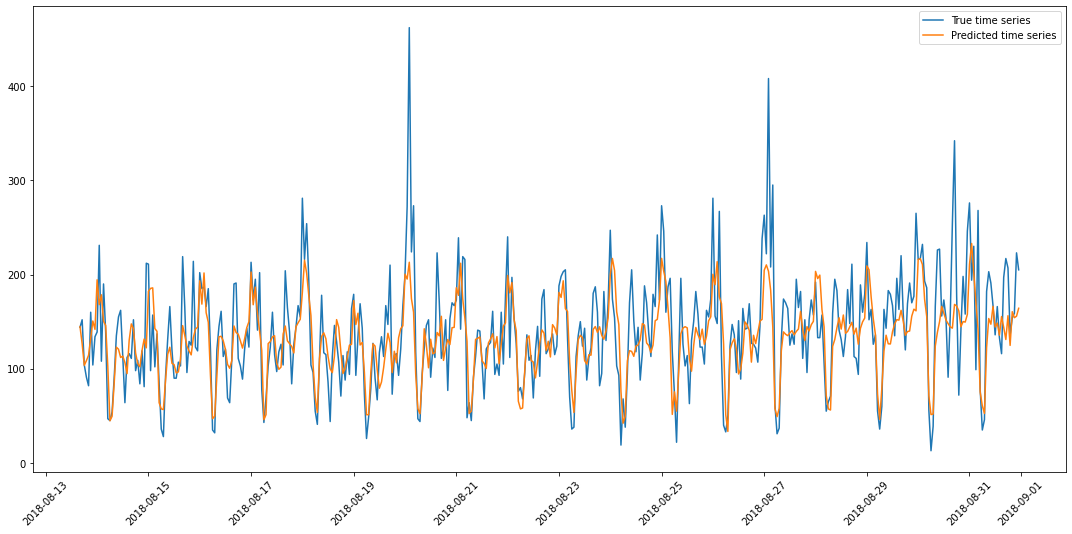

In [63]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='True time series')
plt.plot(pd.Series(pred_test, index=y_test.index), label='Predicted time series')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### DummyRegressor

In [64]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_test)

pred_train = dummy_regr.predict(X_train)
pred_test = dummy_regr.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred_test)**0.5)

RMSE обучающей выборки: 38.70987449386401
RMSE тестовой выборки:  84.68979207380566


Вывод.  
Результат можно считать приемлемым, так как RMSE на тестовой выборке стал лучше в 2 раза.

## Вывод

Были обучены три модели: LinearRegression, LightGBM, RandomForestRegressor. Модели в среднем предсказывают с RMSE = 42.